In [ ]:
%pip install sagemaker boto3 pandas scikit-learn scipy matplotlib sktime==0.14.0 seaborn

In [242]:
import pandas as pd 
import sagemaker
from sagemaker.serializers import NumpySerializer
from sktime.datasets import load_from_tsfile_to_dataframe
from sagemaker.sklearn import SKLearn


In [243]:
prefix = 'itc-timeseries'
train_data = 's3://sagemaker-us-east-1-170802245450/itc-timeseries/train/train.ts'
test_data = 's3://sagemaker-us-east-1-170802245450/itc-timeseries/test/test.ts'
role = 'arn:aws:iam::170802245450:role/service-role/AmazonSageMaker-ExecutionRole-20221013T155418'
bucket = 'sagemaker-us-east-1-170802245450'
output = 's3://{}/{}/output/'.format(bucket, prefix)

In [244]:
def GetTrainingJobAnalytics(training_job_name):
    from sagemaker.analytics import TrainingJobAnalytics
    result = TrainingJobAnalytics(training_job_name).dataframe().drop(columns='timestamp').set_index('metric_name').T.reset_index(drop=True).round(decimals=5)
    result.columns.names = ['']
    result.insert(0, column='job_name', value=[training_job_name])
    return result

In [245]:
def GetInProgressOrStopping():
    training_jobs_in_progress = sagemaker_session.list_training_jobs(
        MaxResults=10,
        StatusEquals='InProgress'
    )

    training_jobs_stopping = sagemaker_session.list_training_jobs(
        MaxResults=10,
        StatusEquals='Stopping'
    )

    return len(training_jobs_in_progress["TrainingJobSummaries"]) + len(training_jobs_stopping["TrainingJobSummaries"])

In [246]:
import boto3
import json
from time import sleep 
sagemaker_session = boto3.client('sagemaker')

In [298]:
#List of algorithms to run
job_spec = pd.DataFrame([
    {'algorithm': 'ROCKET', 'category': 'kernel-based', 'script': 'sktime_train_script_rocket.py'},
    {'algorithm': 'Arsenal', 'category': 'kernel-based', 'script': 'sktime_train_script_arsenal.py'},
    {'algorithm': 'TimeSeriesForestClassifier', 'category': 'interval-based', 'script': 'sktime_train_script_tsfc.py'},
    {'algorithm': 'Catch22', 'category': 'feature-based', 'script': 'sktime_train_script_catch22.py'},
    {'algorithm': 'TSFreshClassifier', 'category': 'feature-based', 'script': 'sktime_train_script_tsfresh.py'},
    {'algorithm': 'FreshPRINCE', 'category': 'feature-based', 'script': 'sktime_train_script_freshprince.py'}
])

metric_definitions = [
                    {'Name': 'pred_time_per_sample', 'Regex':'PredTimePerSample=(.*)'},
                    {'Name': 'accuracy', 'Regex':'Accuracy=(.*)'},
                    {'Name': 'precision', 'Regex':'Precision=(.*)'},
                    {'Name': 'recall', 'Regex':'Recall=(.*)'},
                    {'Name': 'f1', 'Regex':'F1=(.*)'},
                   ]


In [300]:
#Automatic job runner
job_limit = 4
job_spec_selected = job_spec[(job_spec["category"] == 'feature-based') & (job_spec["algorithm"] != "Catch22")]
job_spec_selected

,algorithm,category,script
4,TSFreshClassifier,feature-based,sktime_train_script_tsfresh.py
5,FreshPRINCE,feature-based,sktime_train_script_freshprince.py


In [301]:

jobs = []
for i,job in job_spec_selected.iterrows():

    quota_used = GetInProgressOrStopping()
    #Block when job_limit is reached
    while quota_used >= job_limit:
        print("Reached job limit. Retrying in 60 seconds...")
        sleep(60)
        quota_used = GetInProgressOrStopping()

    print(f'Starting model training...{job["algorithm"]}')
    sk_model = SKLearn(entry_point=job["script"],
                framework_version='0.23-1',
                instance_type='ml.m5.4xlarge',
                role=role,
                output_path=output,
                base_job_name=job["algorithm"],
                source_dir='code',
                script_mode=True,
                use_spot_instances=True,
                max_run = 3600,
                max_wait =7200,
                metric_definitions=metric_definitions)

    sk_model.fit({'train': train_data,
              'test': test_data}, wait=False)

    jobs.append(sk_model._current_job_name)
    print(f'Job started...{sk_model._current_job_name}')


Starting model training...TSFreshClassifier
Job started...TSFreshClassifier-2022-11-14-20-30-17-060
Starting model training...FreshPRINCE
Job started...FreshPRINCE-2022-11-14-20-30-17-796


In [269]:
#Create results dataframe
results_dict = { 'job_name': pd.Series(dtype='str'),
                            'pred_time_per_sample': pd.Series(dtype='float64'),
                            'accuracy': pd.Series(dtype='float64'),
                            'precision': pd.Series(dtype='float64'),
                            'recall': pd.Series(dtype='float64'),
                            'f1': pd.Series(dtype='float64'),
                            'cohens': pd.Series(dtype='float64')}

In [281]:
#Retrieve data
job_list = pd.DataFrame(sagemaker_session.list_training_jobs(MaxResults=10)["TrainingJobSummaries"])
completed_jobs = job_list[job_list["TrainingJobName"].isin(jobs)]

results_df = pd.DataFrame(results_dict)
for i,job in completed_jobs.iterrows():
    results_df = pd.concat([results_df,GetTrainingJobAnalytics(job.TrainingJobName)])

results_df.sort_values("precision", ascending=False)

,job_name,pred_time_per_sample,accuracy,precision,recall,f1,cohens
0,Catch22-2022-11-14-19-40-13-195,0.01305,0.63000,0.35374,0.76471,0.48372,NaN
0,TimeSeriesForestClassifier-2022-11-14-19-40-14...,0.00687,0.57000,0.34518,1.00000,0.51321,NaN
0,Arsenal-2022-11-14-19-40-09-400,0.03338,0.49667,0.31050,1.00000,0.47387,NaN
0,ROCKET-2022-11-14-19-40-08-697,0.07417,0.46000,0.28636,0.92647,0.43750,NaN


In [20]:
# Deploy after model selection

predictor = sk_model.deploy(initial_instance_count=1,
                instance_type="ml.c6g.4xlarge",
                endpoint_name="skrocket-4x",
                serializer=NumpySerializer(), 
                wait=False)

In [ ]:
# X_test_frame = X_test.tail(1).dim_0.to_numpy()

# y_predict = predictor.predict(X_test_frame)

# print(y_predict)

y_predict = []
for i,data in X_test.iterrows():
    frame = data.to_numpy()
    prediction = predictor.predict(frame)[0]
    y_predict.append(prediction)
    print(prediction)

print(y_predict)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

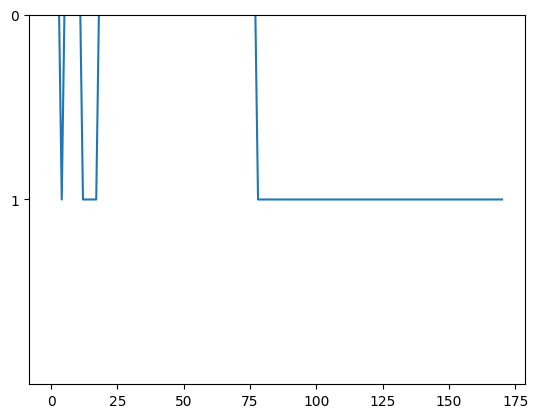

In [36]:
plt.ylim(2,0)
sns.lineplot(y_predict)
plt.show()